In [1]:
import pickle
import os
import sys
import random
sys.path.insert(0, '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset')
sys.path.insert(0, '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/lib')
from lib.datasets.pascal_ctx import PASCALContext
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import OrderedDict
import numpy as np
from pathlib import Path
from scipy.stats import entropy

/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getcwd()

'/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/analysis'

In [3]:
subset_paths = [
    '../data/preprocessing/pascal_ctx_ViT_cossim_0.1_gc_0.1_0.5_stochastic_subsets.pkl',
    '../data/preprocessing/pascal_ctx_ViT_cossim_0.001_gc_0.1_0.5_stochastic_subsets.pkl',
    '../data/preprocessing/pascal_ctx_ViT_cossim_1e-05_gc_0.1_0.5_stochastic_subsets.pkl',
]
print(f'Stochastic subset file exists: {os.path.exists(subset_paths[0])}')

Stochastic subset file exists: True


In [4]:
def pickle2dict(file_name, key):
    """
    Load dictionary from pickle file
    """
    with open(file_name, "rb") as fIn:
        stored_data = pickle.load(fIn)
        value = stored_data[key]
    return value

In [5]:
# if stochastic_subsets[0] == stochastic_subsets[-1]:
#     print('subsets appear to all be the same. Yikes!')

In [6]:
trainset = PASCALContext(
            root='/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/',
            list_path='train',
            num_samples=None,
            num_classes=59,
            multi_scale=True,
            flip=True,
            ignore_label=-1,
            base_size=520,
            crop_size=(520,520),
            downsample_rate=1,
            scale_factor=16,
        )

valset = PASCALContext(
            root='/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/',
            list_path='val',
            num_samples=None,
            num_classes=59,
            multi_scale=True,
            flip=True,
            ignore_label=-1,
            base_size=520,
            crop_size=(520,520),
            downsample_rate=1,
            scale_factor=16,
        )


loading annotations into memory...
JSON root keys:dict_keys(['info', 'images', 'annos_segmentation', 'annos_occlusion', 'annos_boundary', 'categories', 'parts'])
Done (t=3.71s)
creating index...
index created! (t=4.57s)
mask_file: /home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/pascal_ctx/VOCdevkit/VOC2010/train.pth
wait
loading annotations into memory...
JSON root keys:dict_keys(['info', 'images', 'annos_segmentation', 'annos_occlusion', 'annos_boundary', 'categories', 'parts'])
Done (t=4.01s)
creating index...
index created! (t=4.23s)
mask_file: /home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/data/pascal_ctx/VOCdevkit/VOC2010/val.pth
wait


## Image-Wise Class Distributions

In [7]:
trainset_classes = [trainset.get_imagewise_label(file["file_name"]) for file in trainset.files]
trainset_class_dist = {x: trainset_classes.count(x) for x in trainset_classes}
trainset_class_dist = OrderedDict(sorted(trainset_class_dist.items()))
train_df = pd.DataFrame.from_dict(data=trainset_class_dist, orient='index', columns=['trainset'])

valset_classes = [valset.get_imagewise_label(file["file_name"]) for file in valset.files]
valset_class_dist = {x: valset_classes.count(x) for x in valset_classes}
valset_class_dist = OrderedDict(sorted(valset_class_dist.items()))
val_df = pd.DataFrame.from_dict(data=valset_class_dist, orient='index', columns=['valset'])

In [18]:
experiment_dfs = []

for subset_path in subset_paths:
    
    subsets = pickle2dict(subset_path, 'stochastic_subsets')
    stochastic_subsets = []
    for subset in subsets:
        stochastic_subsets.append([x[0] for x in subset])

    class_distributions = []
    subset_dataframes = []
    i=0
    random_subset = random.sample(stochastic_subsets, 10)
    for subset in tqdm(random_subset, total=len(random_subset)):
        subset_classes = [trainset.get_imagewise_label(trainset[index][3]) for index in subset]
        subset_class_dist = {x: subset_classes.count(x) for x in subset_classes}
        subset_class_dist = OrderedDict(sorted(subset_class_dist.items()))
        class_distributions.append(subset_class_dist)
        subset_df = pd.DataFrame.from_dict(data=subset_class_dist, orient='index', columns=[f'subset_{i}'])
        i=i+1
        subset_dataframes.append(subset_df)

    summary_df = pd.DataFrame({'mean':pd.concat(subset_dataframes, axis=1).mean(axis=1), 'var':pd.concat(subset_dataframes, axis=1).var(axis=1)})

    experiment_dfs.append(summary_df)
    

    

100%|██████████| 10/10 [05:05<00:00, 30.50s/it]


<ErrorbarContainer object of 3 artists>

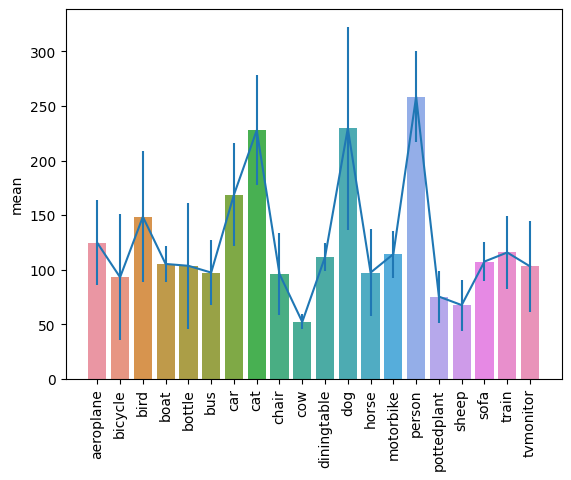

In [19]:
i=0
plt = sns.barplot(data=experiment_dfs[0], x=experiment_dfs[0].index, y='mean')
plt.set_xticklabels(plt.get_xticklabels(),rotation=90)
plt.errorbar(x=experiment_dfs[0].index, y=experiment_dfs[0]['mean'],yerr=experiment_dfs[0]['var'])

In [20]:
subset_means = pd.concat([experiment_dfs[i]['mean'] for i in range(len(experiment_dfs))], axis=1)
subset_means = subset_means.set_axis(['0.1', '0.001', '0.00001'], axis=1)

In [21]:
total_df = pd.concat([subset_means, val_df, train_df], axis=1)

In [22]:
total_df = total_df / total_df.sum()

Text(0, 0.5, '')

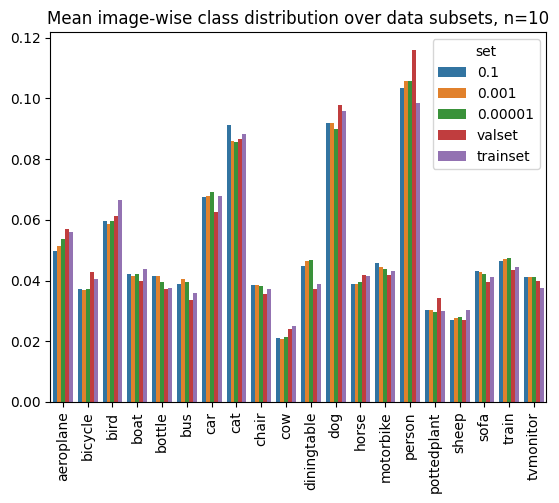

In [26]:
plot_df = total_df.melt(var_name='set', value_name='count', ignore_index=False)
plt = sns.barplot(data=plot_df, x=plot_df.index, y='count', hue='set')
plt.set_xticklabels(plt.get_xticklabels(),rotation=90)
plt.set_title('Mean image-wise class distribution over data subsets, n=10')
plt.set_ylabel('')

In [28]:
subset_vars = pd.concat([experiment_dfs[i]['var'] for i in range(len(experiment_dfs))], axis=1)
subset_vars = subset_vars.set_axis(['0.1', '0.001', '0.00001'], axis=1)

In [29]:
subset_vars.mean()

0.1        37.593333
0.001      20.705556
0.00001    15.190000
dtype: float64

## Pixel-wise class distributions

In [18]:
def get_pixel_dist(dataset):
    uniques = []
    counts = []
    for batch in enumerate(dataset):
        index, (image, labels, shape, name) = batch
        unique, count = np.unique(labels, return_counts=True)
        uniques.append(unique)
        counts.append(count)
    pixel_df = pd.DataFrame({'class': np.concatenate(uniques), 'proportion': np.concatenate(counts)})
    pixel_df = pixel_df.groupby('class').sum()
    pixel_df = pixel_df.drop(index=-1)
    pixel_df = pixel_df / pixel_df.sum()
    return pixel_df

train_pixel_df = get_pixel_dist(trainset)
val_pixel_df = get_pixel_dist(valset)
    

In [75]:
train_pixel_df = train_pixel_df.set_axis(['trainset'], axis=1)
val_pixel_df = val_pixel_df.set_axis(['valset'], axis=1)

In [76]:
experiment_dfs = []

for subset_path in subset_paths:
    
    subsets = pickle2dict(subset_path, 'stochastic_subsets')
    stochastic_subsets = []
    for subset in subsets:
        stochastic_subsets.append([x[0] for x in subset])

    class_distributions = []
    subset_dataframes = []
    i=0
    random_subset = random.sample(stochastic_subsets, 10)
    for subset in tqdm(random_subset, total=len(random_subset)):
        uniques = []
        counts = []
        for index in subset:
            image, labels, shape, name = trainset.__getitem__(index)
            unique, count = np.unique(labels, return_counts=True)
            uniques.append(unique)
            counts.append(count)

        pixel_df = pd.DataFrame({'class': np.concatenate(uniques), 'count': np.concatenate(counts)})
        pixel_df = pixel_df.groupby('class').sum()
        pixel_df = pixel_df.drop(index=-1)
        pixel_df = pixel_df / pixel_df.sum()
            
        subset_dataframes.append(pixel_df)

    summary_df = pd.DataFrame({'mean':pd.concat(subset_dataframes, axis=1).mean(axis=1), 'var':pd.concat(subset_dataframes, axis=1).var(axis=1)})

    experiment_dfs.append(summary_df)

100%|██████████| 10/10 [06:13<00:00, 37.33s/it]


In [77]:
subset_means = pd.concat([experiment_dfs[i]['mean'] for i in range(len(experiment_dfs))], axis=1)
subset_means = subset_means.set_axis(['0.1', '0.001', '0.00001'], axis=1)

total_df = pd.concat([subset_means, val_pixel_df, train_pixel_df], axis=1)

Text(0, 0.5, '')

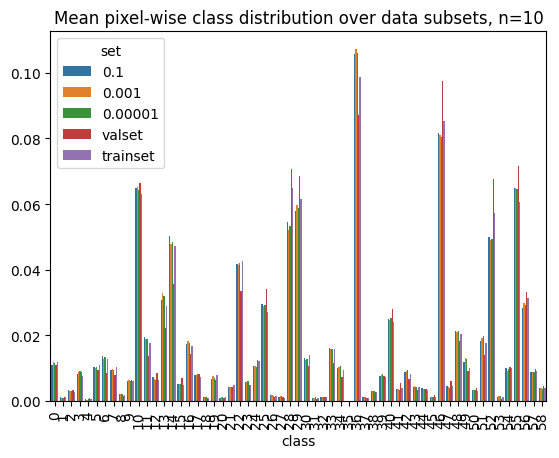

In [78]:
plot_df = total_df.melt(var_name='set', value_name='count', ignore_index=False)
plt = sns.barplot(data=plot_df, x=plot_df.index, y='count', hue='set')
plt.set_xticklabels(plt.get_xticklabels(),rotation=90)
plt.set_title('Mean pixel-wise class distribution over data subsets, n=10')
plt.set_ylabel('')

In [79]:
subset_vars = pd.concat([experiment_dfs[i]['var'] for i in range(len(experiment_dfs))], axis=1)
subset_vars = subset_vars.set_axis(['0.1', '0.001', '0.00001'], axis=1)

In [80]:
subset_vars.mean()

0.1        1.291694e-06
0.001      1.038278e-06
0.00001    8.974925e-07
dtype: float64

In [84]:
print(f'KL divergence between training set and the 0.1 set is: {entropy(pixel_df["count"], subset_vars["0.1"])}')
print(f'KL divergence between training set and the 0.1 set is: {entropy(pixel_df["count"], subset_vars["0.001"])}')
print(f'KL divergence between training set and the 0.1 set is: {entropy(pixel_df["count"], subset_vars["0.00001"])}')

KL divergence between training set and the 0.1 set is: 0.06927961181480845
KL divergence between training set and the 0.1 set is: 0.08536579530986546
KL divergence between training set and the 0.1 set is: 0.21686007339063892


### Correlation of class distribution with validation mIoU

In [16]:
approximate_validation_mIoU = [0.77, 0.13, 0.08, 0.24, 0.02, 0.7, 0.75, 0.57, 0.35, 0.7, 0.5, 0.8, 0.27, 0.78, 0.79, 0.46, 0.35, 0.11, 0.21, 0.55, 0.29, 0.35, 0.75, 0.11, 0.3, 0.58, 0.14, 0.22, 0.73, 0.44, 0.65, 0.61, 0.37, 0.73, 0.42, 0.15, 0.8, 0.15, 0.34, 0.39, 0.41, 0.25, 0.61, 0.19, 0.13, 0.26, 0.91, 0.44, 0.32, 0.47, 0.58, 0.75, 0.73, 0.2, 0.7, 0.58, 0.7, 0.29, 0.13]

In [17]:
train_pixel_df = train_pixel_df.set_axis(['class proportions'], axis=1)
train_pixel_df['mIoU'] = approximate_validation_mIoU

In [18]:
train_pixel_df.corr()

,class proportions,mIoU
class proportions,1.000000,0.585703
mIoU,0.585703,1.000000


Text(0.5, 1.0, 'Validation mIoU vs Class proportions')

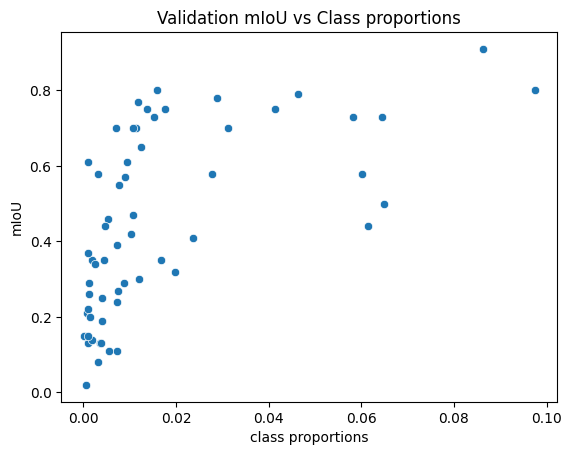

In [26]:
plt = sns.scatterplot(data=train_pixel_df, x='class proportions', y='mIoU')
plt.set_title('Validation mIoU vs Class proportions')

### Epoch Subset Statistics

In [60]:
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorboard.util.tensor_util import make_ndarray
import re

tb_dir = '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/log/pixel_map_weighted_random_sampling_experiment/pascal_ctx/seg_hrnet/'
tb_paths = []
for root, dirs, files in os.walk(tb_dir):
    for file in files:
        if file.endswith(".aa-desktop"):
            tb_paths.append(os.path.join(root, file))

In [61]:
tb_paths

['/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/log/pixel_map_weighted_random_sampling_experiment/pascal_ctx/seg_hrnet/oracle_05_a_2023-09-08-19-31/events.out.tfevents.1694165498.aa-desktop',
 '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/log/pixel_map_weighted_random_sampling_experiment/pascal_ctx/seg_hrnet/invtrainprop_05_a_2023-09-09-21-03/events.out.tfevents.1694257385.aa-desktop',
 '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/log/pixel_map_weighted_random_sampling_experiment/pascal_ctx/seg_hrnet/oracle_05_b_2023-09-09-04-02/events.out.tfevents.1694196135.aa-desktop',
 '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/log/pixel_map_weighted_random_sampling_experiment/pascal_ctx/seg_hrnet

In [62]:
tb_paths.pop(1)
print(tb_paths)

['/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/log/pixel_map_weighted_random_sampling_experiment/pascal_ctx/seg_hrnet/oracle_05_a_2023-09-08-19-31/events.out.tfevents.1694165498.aa-desktop', '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/log/pixel_map_weighted_random_sampling_experiment/pascal_ctx/seg_hrnet/oracle_05_b_2023-09-09-04-02/events.out.tfevents.1694196135.aa-desktop', '/home/nickbarry/Documents/MsC-DS/Data_Science_Research_Project/Coresets/Repositories/HRNet-Semantic-Segmentation-Coreset/log/pixel_map_weighted_random_sampling_experiment/pascal_ctx/seg_hrnet/oracle_05_b_2023-09-09-12-32/events.out.tfevents.1694226757.aa-desktop']


In [63]:
pixel_dfs = []
for tb_path in tqdm(tb_paths, total = len(tb_paths)):
    for epoch in tqdm(range(len(event_acc.Tensors("subset_epoch_indexes/text_summary")))):
        event_acc = EventAccumulator(tb_path)
        event_acc.Reload()
        subset_indexes_str = make_ndarray(event_acc.Tensors("subset_epoch_indexes/text_summary")[epoch].tensor_proto)[0].decode()
        subset_indexes_raw = subset_indexes_str.split(',')
        subset_indexes_names = [re.subn('[^A-Za-z0-9._]','', s)[0] for s in subset_indexes_raw]

        subset_indexes = [trainset.get_img_index(name) for name in subset_indexes_names]

        uniques = []
        counts = []

        for i in range(len(subset_indexes)):
            index = subset_indexes[i]
            index_name = subset_indexes_names[i]
            image, labels, shape, name = trainset.__getitem__(index)
            assert(name==index_name)
            unique, count = np.unique(labels, return_counts=True)
            uniques.append(unique)
            counts.append(count)

        pixel_df = pd.DataFrame({'class': np.concatenate(uniques), 'proportion': np.concatenate(counts)})
        pixel_df = pixel_df.groupby('class').sum()
        pixel_df = pixel_df.drop(index=-1)
        pixel_df = pixel_df / pixel_df.sum()
        pixel_dfs.append(pixel_df)

    

100%|██████████| 3/3 [17:27<00:00, 349.03s/it]


In [64]:
summary_df = pd.DataFrame({'mean':pd.concat(pixel_dfs, axis=1).mean(axis=1), 'var':pd.concat(pixel_dfs, axis=1).var(axis=1)})

In [81]:
plot_df

,Weighted Random Subsets,Training Set
class,,
0,0.011547,0.011119
1,0.000965,0.001009
2,0.003057,0.002947
3,0.007042,0.007078
4,0.000580,0.000592
5,0.010851,0.010650
6,0.013856,0.013843
7,0.009892,0.009987
8,0.001910,0.001743


In [90]:
plot_df = pd.concat([summary_df['mean'], train_pixel_df], axis=1)
plot_df = plot_df.set_axis(['Weighted Random Subsets', 'Training Set'], axis = 1)

Text(0, 0.5, '')

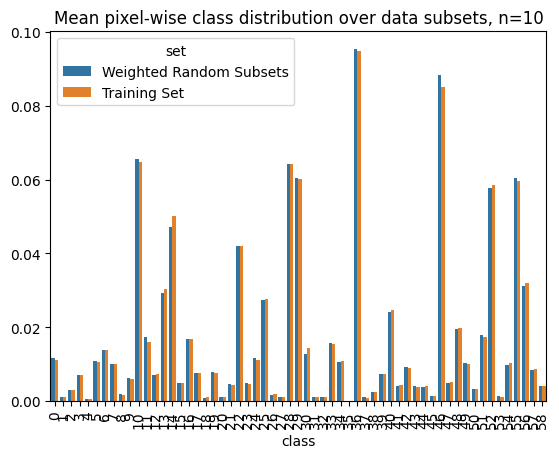

In [83]:
plot_df = plot_df.melt(var_name='set', value_name='count', ignore_index=False)
plt = sns.barplot(data=plot_df, x=plot_df.index, y='count', hue='set')
plt.set_xticklabels(plt.get_xticklabels(),rotation=90)
plt.set_title('Mean pixel-wise class distribution over data subsets, n=10')
plt.set_ylabel('')

Text(0, 0.5, '')

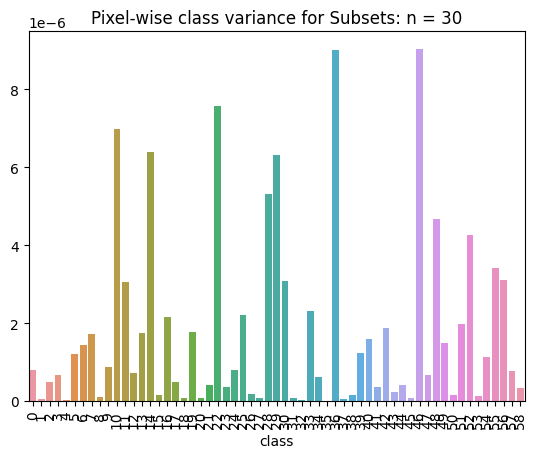

In [87]:
plt = sns.barplot(data=summary_df, x=summary_df.index, y='var')
plt.set_xticklabels(plt.get_xticklabels(),rotation=90)
plt.set_title(f'Pixel-wise class variance for Subsets: n = {len(pixel_dfs)}')
plt.set_ylabel('')

In [89]:
summary_df.corr()

,mean,var
mean,1.00000,0.92874
var,0.92874,1.00000


Text(0, 0.5, '')

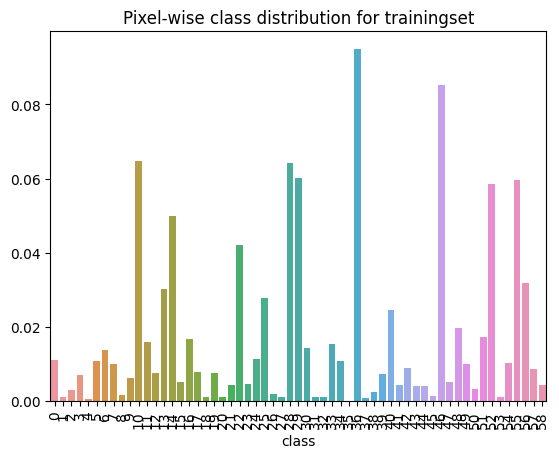

In [19]:
plt = sns.barplot(data=train_pixel_df, x=train_pixel_df.index, y='proportion')
plt.set_xticklabels(plt.get_xticklabels(),rotation=90)
plt.set_title('Pixel-wise class distribution for trainingset')
plt.set_ylabel('')

In [95]:
entropy(plot_df["Weighted Random Subsets"], plot_df["Training Set"])

0.000537255171582457

In [92]:
plot_df

,Weighted Random Subsets,Training Set
class,,
0,0.011547,0.011119
1,0.000965,0.001009
2,0.003057,0.002947
3,0.007042,0.007078
4,0.000580,0.000592
5,0.010851,0.010650
6,0.013856,0.013843
7,0.009892,0.009987
8,0.001910,0.001743


In [14]:
pixel_df['mIoU'] = approximate_validation_mIoU
pixel_df['train_proportions'] = train_pixel_df['class proportions']
print(pixel_df.corr())

NameError: name 'approximate_validation_mIoU' is not defined

In [73]:
print(f'KL divergence between training set and class-wise sampling: {entropy(pixel_df["count"], train_pixel_df["class proportions"])}')
print(f'KL divergence between training set and the validation set is: {entropy(pixel_df["count"], val_pixel_df["valset"])}')

KL divergence between training set and class-wise sampling: 0.015922807772260364
KL divergence between training set and the validation set is: 0.03356792530244201


## Image-Occurence class distributions

In [47]:
def get_image_occurence_dist(dataset):
    uniques = []
    for batch in enumerate(dataset):
        index, (image, labels, shape, name) = batch
        unique = np.unique(labels, return_counts=False)
        uniques.append(unique)
    pixel_df = pd.DataFrame({'class': np.concatenate(uniques)})
    pixel_df.drop(pixel_df[pixel_df['class'] == -1].index, inplace=True)
    return pixel_df

train_pixel_df = get_image_occurence_dist(trainset)
val_pixel_df = get_image_occurence_dist(valset)

In [48]:
train_pixel_df = train_pixel_df.set_axis(['trainset'], axis=1)
val_pixel_df = val_pixel_df.set_axis(['valset'], axis=1)

In [50]:
experiment_dfs = []

for subset_path in subset_paths[:1]:
    
    subsets = pickle2dict(subset_path, 'stochastic_subsets')
    stochastic_subsets = []
    for subset in subsets:
        stochastic_subsets.append([x[0] for x in subset])
    
    class_distributions = []
    subset_dataframes = []
    i=0
    random_subset = random.sample(stochastic_subsets, 10)
    for subset in tqdm(random_subset, total=len(random_subset)):
        uniques = []
        for index in subset:
            image, labels, shape, name = trainset.__getitem__(index)
            unique = np.unique(labels, return_counts=False)
            uniques.append(unique)

        pixel_df = pd.DataFrame({'class': np.concatenate(uniques)})
        pixel_df.drop(pixel_df[pixel_df['class'] == -1].index, inplace=True)
        subset_dataframes.append(pixel_df)

    # summary_df = pd.DataFrame({'mean':pd.concat(subset_dataframes, axis=1).mean(axis=1), 'var':pd.concat(subset_dataframes, axis=1).var(axis=1)})

    # experiment_dfs.append(summary_df)


# experiment_dfs = []

# for subset_path in subset_paths:
    
#     subsets = pickle2dict(subset_path, 'stochastic_subsets')
#     stochastic_subsets = []
#     for subset in subsets:
#         stochastic_subsets.append([x[0] for x in subset])

#     class_distributions = []
#     subset_dataframes = []
#     i=0
#     random_subset = random.sample(stochastic_subsets, 10)
#     for subset in tqdm(random_subset, total=len(random_subset)):
#         uniques = []
#         counts = []
#         for index in subset:
#             image, labels, shape, name = trainset.__getitem__(index)
#             unique, count = np.unique(labels, return_counts=True)
#             uniques.append(unique)
#             counts.append(count)

#         pixel_df = pd.DataFrame({'class': np.concatenate(uniques), 'count': np.concatenate(counts)})
#         pixel_df = pixel_df.groupby('class').sum()
#         pixel_df = pixel_df.drop(index=-1)
#         pixel_df = pixel_df / pixel_df.sum()
            
#         subset_dataframes.append(pixel_df)

#     summary_df = pd.DataFrame({'mean':pd.concat(subset_dataframes, axis=1).mean(axis=1), 'var':pd.concat(subset_dataframes, axis=1).var(axis=1)})

#     experiment_dfs.append(summary_df)

 60%|██████    | 6/10 [04:06<02:44, 41.15s/it]


KeyboardInterrupt: 

In [42]:
# filtered = train_pixel_df.groupby(train_pixel_df.index).filter(lambda x: x != -1)

In [51]:
total_df = pd.concat([train_pixel_df, val_pixel_df] + subset_dataframes)

In [55]:
plot_df = total_df.melt(var_name='set', value_name='count', ignore_index=False)

<Axes: ylabel='Count'>

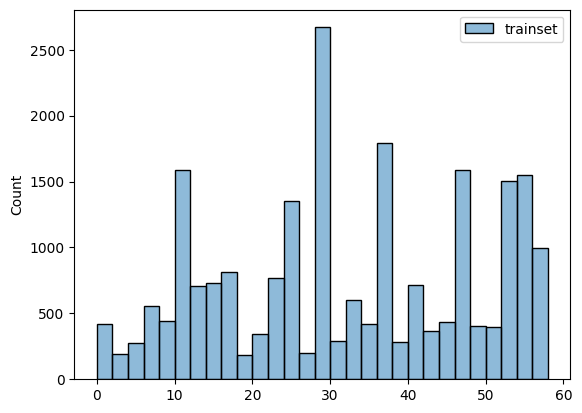

In [61]:
sns.histplot(train_pixel_df)

<Axes: ylabel='Count'>

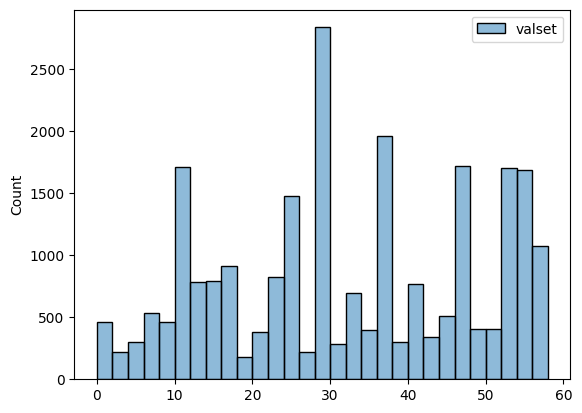

In [62]:
sns.histplot(val_pixel_df)

<Axes: ylabel='Count'>

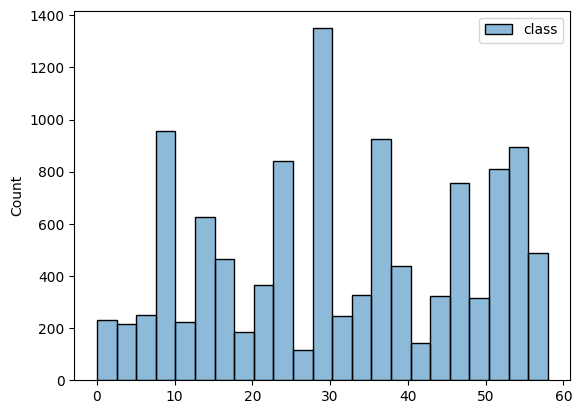

In [64]:
sns.histplot(subset_dataframes[0])